In [421]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df=pd.read_csv("cars_train.csv")

In [4]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,lat,long,posting_date
0,7226069143,indianapolis,3495,2005.0,lincoln,lse,good,8 cylinders,gas,181000.0,automatic,rwd,sedan,silver,in,39.640500,-86.311800,2020-11-05T16:19:56-0500
1,7233322668,medford-ashland,11995,2011.0,subaru,impreza,good,4 cylinders,gas,69408.0,automatic,4wd,wagon,blue,or,45.524894,-122.656061,2020-11-18T15:45:51-0800
2,7239134076,austin,68990,2016.0,porsche,cayman gts coupe 2d,good,NaN,gas,7923.0,automatic,rwd,coupe,red,tx,30.260000,-97.740000,2020-11-30T02:13:53-0600
3,7238509078,hawaii,17900,2011.0,bmw,535i,NaN,NaN,gas,50193.0,automatic,NaN,sedan,black,hi,21.293854,-157.837158,2020-11-28T13:57:30-1000
4,7236364831,daytona beach,9500,2006.0,NaN,mazada miata,excellent,4 cylinders,gas,52864.0,automatic,rwd,convertible,blue,fl,29.172023,-81.027367,2020-11-24T12:48:43-0500


# Baseline System

In this section, I have chosen the columns that I feel will have a predicition power. Since they consititute the majority, I will be discussing why I dropped certain columns:


*   id: This column does not have any predictive power.
*   paint_color: Colors should not have any say on the price of a car


*   lat and long: These will be dropped since we are keeping the regions and the states

The idea behind the script in this section is the following. First, we will be dropping columns that contain more than 30% missing values, as we do not want to be missing a lot of rows. For the categorical variables with less missing values, we will remove the rows with missing values. For the numerical variables, we will be replacing by the median.

**The mean of the RMSE in this model is 193999.21 and the standard deviation is 216255.81.**




In [ ]:
#Choosing the feature that I think have predictor power
df_imp=df[["price","year","condition","cylinders","fuel","odometer","transmission","drive","type","posting_date","state","region","model","manufacturer"]]

In [ ]:
#I will be removing columns with more than 30% nas
df_imp = df_imp.loc[:, df_imp.isnull().mean() <= 0.3]
#I will be dropping all the Na rows in categorical variables
df_imp.dropna(subset=['drive', 'type','transmission','fuel',"model","manufacturer"], inplace=True)

In [ ]:
#Detaching the Price form the rest of the variables. Also, I removed the posting_date since it has no prediction power
Y=df_imp.price
X=df_imp.drop(['price','posting_date'], axis = 1)

Here, we are performing one hot encoding on the categorical variables and we are replacing by the median for numerical variables.

In [ ]:
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])

As you can see, the RMSE is really bad, and a deep preprocessing technics as long as feature engineering should be implemented to enhance the model performance.

In [ ]:
lin_reg = LinearRegression()
cv = cross_val_score(clf, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
mean=cv.mean()
std=cv.std()
print("The mean is {} and the standard deviation is {}".format(abs(mean),std))

The mean is 193999.2172384339 and the standard deviation is 216255.81046560736


# Feature Engineering


**a) Augmented Features Discussion**

1.   Removing Outliers: First, I was surprised about how influential was removing the outliers from the price and odometer columns. I have noticed that the odometer column did not have any prediction power before Removing outliers
2.   Creating a new column out of the manufacturer column: Here, I was able to engineer a new column using the manufacturer column. Basically, I grouped the 44 categories into 3 categories, according to how premium these brand are. For instance, I would group ferrari and porsche on one, kia and toyota on another group. 
1.   Creating an Age column: Using the year and the posting_date, I was able to create an age column, simply by applying the difference between the year of the posting_date column and the year column. This did not affect the accuracy of the model but it will be used to create the next feature.
1.   Created a age/odometer rate: This new column ehanced slightly the error.
1.   The model column was an important column. This is surprising because this column has a more than 10000 categories and I thought that it would have been so noisy to the model.












In [ ]:
#Choosing the feature that I think have predictor power
df_imp=df[["price","year","condition","cylinders","fuel","odometer","transmission","drive","type","posting_date","state","region","model","manufacturer"]]

1. Removing Outliers: I have decided to remove cars with prices above 200000.
I thought that 200000$ as a price tag is too high even for new cars. I removed also odometer with more than 200000 in odometer. Cars with more than 200000 are for the most part mal functioning cars. While  some people might post these type of cars, it is best to remove them as they might posted just for the sake of joking and thus presenting an outlier.

**After removing outliers, the mean of the RMSE improved drastically. It is now aound 5903 and the standard deviation is around 183**

In [ ]:
#Removing outliers
df_imp=df_imp[df_imp["price"]>1000]
df_imp=df_imp[df_imp["price"]<200000]
df_imp=df_imp[df_imp["odometer"]>1000]
df_imp=df_imp[df_imp["odometer"]<200000]
#I will be removing columns with more than 30% nas
df_imp = df_imp.loc[:, df_imp.isnull().mean() <= 0.3]
#I will be dropping all the Na rows in categorical variables
df_imp.dropna(subset=['drive', 'type','transmission','fuel',"model","manufacturer"], inplace=True)

In [ ]:
#Seperating predictors from the variable that we want to predict
Y=df_imp.price
X=df_imp.drop(['price','posting_date'], axis = 1)

In [ ]:
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])

In [ ]:
lin_reg = LinearRegression()
cv = cross_val_score(clf, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
mean=cv.mean()
std=cv.std()
print("The mean is {} and the standard deviation is {}".format(abs(mean),std))

The mean is 5903.701124852758 and the standard deviation is 183.68241516616405


2. Now, we are going to create a new column that groups known expensive brand, middle class brand and cheap brand in different categories. Once this is done, we will be dropping the manufacturer category.

**Thanks to this new category, the mean of the RMSE dropped from 5903 to 5554. The standard deviation also dropped from 183 to 72**

In [6]:
#Choosing the feature that I think have predictor power
df_imp=df[["price","year","condition","cylinders","fuel","odometer","transmission","drive","type","posting_date","state","region","model","manufacturer"]]
#Removing outliers
df_imp=df_imp[df_imp["price"]>1000]
df_imp=df_imp[df_imp["price"]<200000]
df_imp=df_imp[df_imp["odometer"]>1000]
df_imp=df_imp[df_imp["odometer"]<200000]
#I will be removing columns with more than 30% nas
df_imp = df_imp.loc[:, df_imp.isnull().mean() <= 0.3]
#I will be dropping all the Na rows in categorical variables
df_imp.dropna(subset=['drive', 'type','transmission','fuel',"model","manufacturer"], inplace=True)

Here, we decided to create 2 lists to combine different brands based on how premium they are. After that, we create a function that will allow us to create these 3 categories in a dataframe column called Class.

In [ ]:
ClassA=["porsche","porsche","tesla","jaguar","ferrari","morgan","hennessey"]
ClassB=["bmw","dodge","mercedes-benz","jeep","ram","chevrolet","cadillac","gmc","volkswagen","audi","lexus","infiniti","chrysler","rover","alpha-romeo"
"harley-davidson","land rover"]
def classifier(row):
    if row['manufacturer'] in ClassA:
        val = "Class A"
    elif row['manufacturer'] in ClassB:
        val = "Class B"
    else:
        val="Class C"
    return val
df_imp['Class'] = df_imp.apply(classifier, axis=1)

In [ ]:
#We dropped the manufacturer column.
Y=df_imp.price
X=df_imp.drop(['price','manufacturer','posting_date'], axis = 1)

In [ ]:
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])
lin_reg = LinearRegression()
cv = cross_val_score(clf, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
mean=cv.mean()
std=cv.std()
print("The mean is {} and the standard deviation is {}".format(abs(mean),std))

The mean is 5554.763727001555 and the standard deviation is 72.61619531287148


3. Now, we will be creating an age column. We will also drop the year column as it will contain the same information as age. I will not be reporting the change for this newly created column as there is no changes. However, the age column will be used to create the odometer/year rate column.

**This new column decreased the mean of RMSE from 5554 to 5521 with a minimal increase in the standard deviation from 72 to 74**

In [ ]:
df_imp=df[["price","year","condition","cylinders","fuel","odometer","transmission","drive","type","posting_date","state","region","model","manufacturer"]]
#Creating the Age variable
df_imp[["Date","Time"]]= df_imp["posting_date"].astype(str).str.split("T", expand = True)
df_imp.pop("posting_date")
df_imp.pop("Time")
df_imp['Date'] = df_imp['Date'].astype('datetime64[ns]')
df_imp['Date'] = df_imp['Date'].dt.year
df_imp["Age"]=df_imp['Date']-df_imp['year']
df_imp.pop("Date")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

0         2020.0
1         2020.0
2         2020.0
3         2020.0
4         2020.0
           ...  
320744    2020.0
320745    2020.0
320746    2020.0
320747    2020.0
320748    2020.0
Name: Date, Length: 320749, dtype: float64

In [7]:
df_imp=df_imp[df_imp["price"]>1000]
df_imp=df_imp[df_imp["price"]<200000]
df_imp=df_imp[df_imp["odometer"]>1000]
df_imp=df_imp[df_imp["odometer"]<200000]
#I will be removing columns with more than 30% nas
df_imp = df_imp.loc[:, df_imp.isnull().mean() <= 0.3]
#I will be dropping all the Na rows in categorical variables
df_imp.dropna(subset=['drive', 'type','transmission','fuel',"model","manufacturer"], inplace=True)

df_imp.pop("year")
ClassA=["porsche","porsche","tesla","jaguar","ferrari","morgan","hennessey"]
ClassB=["bmw","dodge","mercedes-benz","jeep","ram","chevrolet","cadillac","gmc","volkswagen","audi","lexus","infiniti","chrysler","rover","alpha-romeo"
"harley-davidson","land rover"]
def classifier(row):
    if row['manufacturer'] in ClassA:
        val = "Class A"
    elif row['manufacturer'] in ClassB:
        val = "Class B"
    else:
        val="Class C"
    return val
df_imp['Class'] = df_imp.apply(classifier, axis=1)
df_imp=df_imp.reset_index()

#Creating the new column.
df_imp["Odermeter_year"]=round(df_imp["Age"]/df_imp["odometer"],2)

KeyError: 'Age'

In [ ]:
Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)

In [ ]:
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])
lin_reg = LinearRegression()
cv = cross_val_score(clf, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
mean=cv.mean()
std=cv.std()
print("The mean is {} and the standard deviation is {}".format(abs(mean),std))

The mean is 5521.596099531194 and the standard deviation is 74.35695369899629


4. We will remove the model column. We will notice that the RMSE will increase.

**After removing the model column, the RMSE icreased from 5521 to 7468**

In [ ]:
df_imp=df[["price","year","condition","cylinders","fuel","odometer","transmission","drive","type","posting_date","state","region","manufacturer"]]
#Creating the Age variable
df_imp[["Date","Time"]]= df_imp["posting_date"].astype(str).str.split("T", expand = True)
df_imp.pop("posting_date")
df_imp.pop("Time")
df_imp['Date'] = df_imp['Date'].astype('datetime64[ns]')
df_imp['Date'] = df_imp['Date'].dt.year
df_imp["Age"]=df_imp['Date']-df_imp['year']
df_imp.pop("Date")


df_imp=df_imp[df_imp["price"]>1000]
df_imp=df_imp[df_imp["price"]<200000]
df_imp=df_imp[df_imp["odometer"]>1000]
df_imp=df_imp[df_imp["odometer"]<200000]
#I will be removing columns with more than 30% nas
df_imp = df_imp.loc[:, df_imp.isnull().mean() <= 0.3]
#I will be dropping all the Na rows in categorical variables
df_imp.dropna(subset=['drive', 'type','transmission','fuel',"manufacturer"], inplace=True)

df_imp.pop("year")
ClassA=["porsche","porsche","tesla","jaguar","ferrari","morgan","hennessey"]
ClassB=["bmw","dodge","mercedes-benz","jeep","ram","chevrolet","cadillac","gmc","volkswagen","audi","lexus","infiniti","chrysler","rover","alpha-romeo"
"harley-davidson","land rover"]
def classifier(row):
    if row['manufacturer'] in ClassA:
        val = "Class A"
    elif row['manufacturer'] in ClassB:
        val = "Class B"
    else:
        val="Class C"
    return val
df_imp['Class'] = df_imp.apply(classifier, axis=1)
df_imp=df_imp.reset_index()

#Creating the new column.
df_imp["Odermeter_year"]=round(df_imp["Age"]/df_imp["odometer"],2)


Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)

numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])
lin_reg = LinearRegression()
cv = cross_val_score(clf, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
mean=cv.mean()
std=cv.std()
print("The mean is {} and the standard deviation is {}".format(abs(mean),std))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

The mean is 7468.955265235369 and the standard deviation is 54.59240366304103


**b) limitations/obstacles**

One of the obstacles I faced is dropping columns that I believed has some predictive power, just because they contain multiple missing values. These missing values are difficult to replace since they are categorical variables. Removing rows from these columns could end up removing a lot of information as well. This is why I decided to drop columns that contain more than 30% missing values.

Other limitations was concerning the memory limitations. I did not face such a problem, but if I did face it, then I would have reduced the number of category in a categorical columns. Basically, I would have grouped categories that are not really frequent together, in a group called other to reduce the number of categories and thus the number of columns when one hot encoding.


**c) Report the new average RMSE and standard deviation**

The average RMSE is around 5521 and the standard deviation is around 74.

# Model Optimization and Selection

The first model that I will be testing is the linearSVC. Note here that I have tried the SVC but it was taking too much time to just train a model with 5 fold cross validation. I would expect it also to take even more with gridsearch as I am testing multiple models with different parameters and kernels. I searched the web and found out that there is a faster alternative which is LinearSVC.

In [481]:
df_imp=df[["price","year","condition","cylinders","fuel","odometer","transmission","drive","type","posting_date","state","region","manufacturer", "model"]]
#Creating the Age variable
df_imp[["Date","Time"]]= df_imp["posting_date"].astype(str).str.split("T", expand = True)
df_imp.pop("posting_date")
df_imp.pop("Time")
df_imp['Date'] = df_imp['Date'].astype('datetime64[ns]')
df_imp['Date'] = df_imp['Date'].dt.year
df_imp["Age"]=df_imp['Date']-df_imp['year']
df_imp.pop("Date")

df_imp=df_imp[df_imp["price"]>1000]
df_imp=df_imp[df_imp["price"]<200000]
df_imp=df_imp[df_imp["odometer"]>1000]
df_imp=df_imp[df_imp["odometer"]<200000]
#I will be removing columns with more than 30% nas
df_imp = df_imp.loc[:, df_imp.isnull().mean() <= 0.3]
#I will be dropping all the Na rows in categorical variables
df_imp.dropna(subset=['drive', 'type','transmission','fuel',"manufacturer","model"], inplace=True)

df_imp.pop("year")
ClassA=["porsche","porsche","tesla","jaguar","ferrari","morgan","hennessey"]
ClassB=["bmw","dodge","mercedes-benz","jeep","ram","chevrolet","cadillac","gmc","volkswagen","audi","lexus","infiniti","chrysler","rover","alpha-romeo"
"harley-davidson","land rover"]
def classifier(row):
    if row['manufacturer'] in ClassA:
        val = "Class A"
    elif row['manufacturer'] in ClassB:
        val = "Class B"
    else:
        val="Class C"
    return val
df_imp['Class'] = df_imp.apply(classifier, axis=1)
df_imp=df_imp.reset_index()

#Creating the new column.
df_imp["Odermeter_year"]=round(df_imp["Age"]/df_imp["odometer"],2)

Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor',preprocessor), ('LinearSVR', LinearSVR())])

In the below code, we are training our model using 5 fold cross validation with multiple parameters. C is ranging from 1 to 91 with a jump of 10.

In [ ]:
param_grid = {
    'LinearSVR__C': np.arange(0.01,100,10),
}
search = GridSearchCV(clf, param_grid, cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1)

In [ ]:
search.fit(X,Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
search.best_params_


{'LinearSVR__C': 90.01}

**The best hyperparameter is C=90.01**

In [ ]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152590 entries, 0 to 152589
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           152590 non-null  int64  
 1   price           152590 non-null  int64  
 2   fuel            152590 non-null  object 
 3   odometer        152590 non-null  float64
 4   transmission    152590 non-null  object 
 5   drive           152590 non-null  object 
 6   type            152590 non-null  object 
 7   state           152590 non-null  object 
 8   region          152590 non-null  object 
 9   manufacturer    152590 non-null  object 
 10  model           152590 non-null  object 
 11  Age             152590 non-null  float64
 12  Class           152590 non-null  object 
 13  Odermeter_year  152590 non-null  float64
dtypes: float64(3), int64(2), object(9)
memory usage: 16.3+ MB


The next model that we will build is the decision tree model

In [ ]:
Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor',preprocessor), ('DecisionTreeRegressor', DecisionTreeRegressor())])

Next, we will used the Decision trees and optimize its parameters as well.

In [ ]:
param_grid = {
    'DecisionTreeRegressor__max_features': [2,4,6,8,10,12]
}
search = GridSearchCV(clf, param_grid, cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1)

In [ ]:
search.fit(X,Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

The best parameter found was max_features equal to **8**.

In [ ]:
search.best_params_

{'DecisionTreeRegressor__max_features': 8}

Finally, we tested the random forest with bootstrapping

In [487]:
Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor',preprocessor), ('RandomDecisionTreeRegressor', RandomForestRegressor())])

In [488]:
#I will not play with the max feature at the moment. I will dropping unimportant columns later on
from sklearn.model_selection import RandomizedSearchCV
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'RandomDecisionTreeRegressor__n_estimators': [5,10,25],'RandomDecisionTreeRegressor__max_depth':[10,100,1000]}
  ]

forest_reg = RandomForestRegressor()

search = RandomizedSearchCV(clf, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=-1)
search.fit(X, Y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['index',
                                                                                'odometer',
                                                                                'Age',
                                                                                'Odermeter_year'])

The best Parameter found was 25 for n_estimators and 1000 max_depth.

In [489]:
search.best_params_

{'RandomDecisionTreeRegressor__n_estimators': 25,
 'RandomDecisionTreeRegressor__max_depth': 1000}

In [490]:
search.cv_results_

{'mean_fit_time': array([  23.58071432,   45.25649252,  111.52395463,  445.53328123,
         888.55885458, 2203.72140684,  464.97942171,  910.40271597,
        2011.16834884]),
 'std_fit_time': array([  0.38565382,   0.3850895 ,   1.33762104,   2.69216492,
          3.76837952,  21.84282719,   8.13244025,   7.33594167,
        345.28535547]),
 'mean_score_time': array([0.30942235, 0.33980508, 0.42116113, 0.42995515, 0.52449975,
        0.86850462, 0.48332472, 0.56187911, 0.71479025]),
 'std_score_time': array([0.01488572, 0.01907886, 0.01700468, 0.03311866, 0.03522512,
        0.04398479, 0.12742663, 0.0886631 , 0.13260351]),
 'param_RandomDecisionTreeRegressor__n_estimators': masked_array(data=[5, 10, 25, 5, 10, 25, 5, 10, 25],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_RandomDecisionTreeRegressor__max_depth': masked_array(data=[10, 10, 10, 100, 100, 100, 1000, 100

In [491]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", search.best_estimator_)
print("\n The best score across ALL searched params:\n", search.best_score_)
print("\n The best parameters across ALL searched params:\n", search.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['index', 'odometer', 'Age',
                                                   'Odermeter_year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fuel', 'transmission',
                                                   'drive', 'type', 'state',
                                     

**a) For each model, report the average RMSE and the standard deviation**

Here, I retested every model with the best parameter to choose between the better one. I know I could have done this immediately with gridsearchcv however I lost everthing due to google colab reconnecting and I decided not to repeat all the training. Luckily I had the best parameters.

In [483]:
Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor',preprocessor), ('LinearSVR', LinearSVR(C=90.1))])

In [484]:
cv = cross_val_score(clf, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
print("The mean is {} and the standard deviation is {}".format(abs(cv.mean()),cv.std()))

The mean is 7039.849666018163 and the standard deviation is 44.4900253309919


In [485]:
Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor',preprocessor), ('DecisionTreeRegressor', DecisionTreeRegressor(max_features=8))])

In [486]:
cv = cross_val_score(clf, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
print("The mean is {} and the standard deviation is {}".format(abs(cv.mean()),cv.std()))

The mean is 8823.519197483465 and the standard deviation is 417.2980030637792


In [6]:
Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor',preprocessor), ('RandomDecisionTreeRegressor', RandomForestRegressor(n_estimators=10, max_depth=1000))])

In [7]:
cv = cross_val_score(clf, X, Y, cv = 5,scoring='neg_root_mean_squared_error')

In [9]:
print("The mean is {} and the standard deviation is {}".format(abs(cv.mean()),cv.std()))

The mean is 4382.452435582307 and the standard deviation is 117.98835279263088


In [16]:
Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor',preprocessor), ('RandomDecisionTreeRegressor', RandomForestRegressor(n_estimators=25, max_depth=1000))])

In [17]:
cv = cross_val_score(clf, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
print("The mean is {} and the standard deviation is {}".format(abs(cv.mean()),cv.std()))

The mean is 4369.134307783155 and the standard deviation is 140.82873330688173


**b) Select the overall best model for the next step**

The best model that should be chosen is random forest with bootstrapping, with n_estimators equal to 25 and max_depth equal to 1000. However, given the minimal differnece between the n_estimators 10, we will be sticking with the random forest model with n_estimators equal to 10 and 1000, which takes less time to train.

# Feature Selection

**a) Investigate the feature importance calculated inside the model (coef_ or feature_importances_ attribute), compare that to the results of applying RFECV and make your decision on what feature to drop**

In this section, we will be trying to find the features with little to no effect on the RMSE and we will be trying to remove them. To do so, we will be focusing mainly on the feature_importances_, while also comparing the result to the RFECV.

The first step is to train to model chosen, in order to extract the important features.

In [9]:
Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('one_hot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor',preprocessor), ('RandomDecisionTreeRegressor', RandomForestRegressor(n_estimators=10, max_depth=1000, bootstrap=True))])

clf.fit(X, Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['index', 'odometer', 'Age',
                                                   'Odermeter_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fuel', 'transmission',
                                                   'drive', 'type', 'state',
                  

Here, I have used a special method that I found on the internet. I was struggling to extract the feature importance with the one hot encoding. 

In [13]:
onehot_columns=clf.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['one_hot'].get_feature_names(categorical_features)

numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

import eli5
eli5.explain_weights(clf.named_steps['RandomDecisionTreeRegressor'], top=50, feature_names=numeric_features_list, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.3301 ± 0.0073,Age
0.1912 ± 0.0062,drive_fwd
0.1393 ± 0.0040,odometer
0.0609 ± 0.0051,fuel_diesel
0.0159 ± 0.0020,type_pickup
0.0123 ± 0.0012,type_truck
0.0082 ± 0.0054,Class_Class C
0.0070 ± 0.0005,index
0.0057 ± 0.0020,Class_Class A
0.0051 ± 0.0011,type_sedan


**c) What are the top 3 features (most powerful predictors)? Does it make sense?**

Here, I managed to find a way to display all the coefficient of the feature_importances_ with the column name. We found immediately that the result are comparable to the first one. We also, can notice that the top 3 features are AGE, drive_fwd and odometer which makes perfect sense. Age and odometer make perfect sense because as the car gets older, it will get cheaper. Also, front wheel cars are moslty fast cars which are usually expensive.

(question b is answered later on)

In [14]:
onehot_columns = onehot_columns.tolist()
Features=["index","odometer","Age","Odermeter_year"]+onehot_columns

imp=clf.named_steps['RandomDecisionTreeRegressor'].feature_importances_ 
df2 = pd.DataFrame(imp, columns = ['Coeff'])
df3=pd.DataFrame(Features, columns = ['Column_B'])
df2["Feautre"]=df3["Column_B"]
df2.sort_values(by=['Coeff'],ascending=False)

,Coeff,Feautre
2,0.330135,Age
13,0.191151,drive_fwd
1,0.139318,odometer
4,0.060931,fuel_diesel
23,0.015854,type_pickup
...,...,...
4486,0.000000,model_diesels cummins
4484,0.000000,model_diesels 5.9 slt
4483,0.000000,model_diesel rabbit truck
4482,0.000000,model_diesel pickup


Here, the RFECV was made. Please not that i have done the preprocessing before training, which may lead to some data leakage. The thing is, I was struggling with and error, and that the preprocessing should be done before using RFECV.

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFECV

Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('one_hot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X=preprocessor.fit_transform(X)

 Here, I decided to go with 3 time cross validation just because I did not want the training to take too long. I also  increased the step to 1000. We notice that the optimal number of features suggested was at 10573. I was able to find the indices of these features as well, using np.where. I decided to compare these with how many feature with coefficient 0 we foun on the feature importance. We will see the result next.

In [37]:
#I will be doing 3 time cross validation in here just to make it easire to train
dtree= RandomForestRegressor(n_estimators=10, max_depth=1000, bootstrap=True)
rfecv=RFECV(dtree,step=1000,scoring="neg_root_mean_squared_error",cv=3,verbose=1, n_jobs=-1)

rfecv.fit(X, Y)
rfecv.transform(X)
print(rfecv)
print(rfecv.n_features_)

Fitting estimator with 13573 features.
Fitting estimator with 12573 features.
Fitting estimator with 11573 features.
RFECV(cv=3, estimator=RandomForestRegressor(max_depth=1000, n_estimators=10),
      n_jobs=-1, scoring='neg_root_mean_squared_error', step=1000, verbose=1)
10573


Here, the compariso was made. We had 1549 of features that had 0 as coefficient of importance. Between these, 694 were selected by the RFCEV, which is about 50%

In [30]:
df2[df2["Coeff"]==0].shape

(1549, 2)

In [60]:
toberemoved=np.where(rfecv.support_==False)[0]
update_df = df2.drop(toberemoved)
update_df[update_df["Coeff"]==0].shape

(694, 2)

As i mentionned before, I will be fousing mainly on the feature_importances_ to do the features selection. Since these features are mostly categories, I have decided to replace them all by "other" in the initial dataframe. This way, when the one hot encoding happens, we will have a considerable decrease in the number of features.

In [34]:
df_0=df2[df2["Coeff"]==0]

In [36]:
df_0[["Column","Feature_Cat"]]= df_0.Feautre.str.split("_",expand=True)

In [41]:
df_0.drop(["Feautre"], inplace=True, axis=1)

In [44]:
listings_=df_0["Feature_Cat"].tolist()

In [307]:
df_imp=df[["price","year","condition","cylinders","fuel","odometer","transmission","drive","type","posting_date","state","region","manufacturer", "model"]]
df_imp.replace(to_replace =listings_, 
                            value ="other",inplace=True)
#Creating the Age variable
df_imp[["Date","Time"]]= df_imp["posting_date"].astype(str).str.split("T", expand = True)
df_imp.pop("posting_date")
df_imp.pop("Time")
df_imp['Date'] = df_imp['Date'].astype('datetime64[ns]')
df_imp['Date'] = df_imp['Date'].dt.year
df_imp["Age"]=df_imp['Date']-df_imp['year']
df_imp.pop("Date")
df_imp=df_imp[df_imp["price"]>1000]
df_imp=df_imp[df_imp["price"]<200000]
df_imp=df_imp[df_imp["odometer"]>1000]
df_imp=df_imp[df_imp["odometer"]<200000]
#I will be removing columns with more than 30% nas
df_imp = df_imp.loc[:, df_imp.isnull().mean() <= 0.3]
#I will be dropping all the Na rows in categorical variables
df_imp.dropna(subset=['drive', 'type','transmission','fuel',"manufacturer","model"], inplace=True)

df_imp.pop("year")
ClassA=["porsche","porsche","tesla","jaguar","ferrari","morgan","hennessey"]
ClassB=["bmw","dodge","mercedes-benz","jeep","ram","chevrolet","cadillac","gmc","volkswagen","audi","lexus","infiniti","chrysler","rover","alpha-romeo"
"harley-davidson","land rover"]
def classifier(row):
    if row['manufacturer'] in ClassA:
        val = "Class A"
    elif row['manufacturer'] in ClassB:
        val = "Class B"
    else:
        val="Class C"
    return val
df_imp['Class'] = df_imp.apply(classifier, axis=1)
df_imp=df_imp.reset_index()

#Creating the new column.
df_imp["Odermeter_year"]=round(df_imp["Age"]/df_imp["odometer"],2)

Y=df_imp.price
X=df_imp.drop(['price','manufacturer'], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf2 = Pipeline(steps=[('preprocessor',preprocessor), ('RandomDecisionTreeRegressor', RandomForestRegressor(n_estimators=10, max_depth=1000, bootstrap=True))])

**b) Report the percentage reduction in feature size and the RMSE for the selected feature set**

**I tested, to see whether there is an effect on the RMSE. It turns out that the RMSE was affected by about 20, which around 1% decrease. This is good, since we reduced the number of features to around 10% decrease.**

In [308]:
#RMSE decreased slightly
cv = cross_val_score(clf2, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
print("The mean is {} and the standard deviation is {}".format(abs(cv.mean()),cv.std()))

The mean is 4388.04630652641 and the standard deviation is 111.74404961024011


# Pipeline, Interpretable Model, and Final Testing.

**a)But before your final evaluation try to further optimize the parameters of an interpretable model (e.g., Decision Tree or Linear Regression) and get it to achieve a comparable performance to your best model (in step 3):**

**o Use the pipeline and GridSearchCV for this task**

**o Discuss your findings and select your final model for deployment (testing)**

We started first by removing the outliers and such. I thought about not including these in the pipeline.

In [325]:
df_imp=df[["price","year","fuel","odometer","transmission","drive","type","posting_date","state","region","manufacturer", "model"]]
#Creating the Age variable

df_imp=df_imp[df_imp["price"]>1000]
df_imp=df_imp[df_imp["price"]<200000]
df_imp=df_imp[df_imp["odometer"]>1000]
df_imp=df_imp[df_imp["odometer"]<200000]

df_imp[["Date","Time"]]= df_imp["posting_date"].astype(str).str.split("T", expand = True)
df_imp.pop("posting_date")
df_imp.pop("Time")
df_imp['Date'] = df_imp['Date'].astype('datetime64[ns]')
df_imp['Date'] = df_imp['Date'].dt.year



df_imp.dropna(subset=['drive', 'type','transmission','fuel',"manufacturer","model"], inplace=True)
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152590 entries, 0 to 320744
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         152590 non-null  int64  
 1   year          152590 non-null  float64
 2   fuel          152590 non-null  object 
 3   odometer      152590 non-null  float64
 4   transmission  152590 non-null  object 
 5   drive         152590 non-null  object 
 6   type          152590 non-null  object 
 7   state         152590 non-null  object 
 8   region        152590 non-null  object 
 9   manufacturer  152590 non-null  object 
 10  model         152590 non-null  object 
 11  Date          152590 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 15.1+ MB


Here, we created a custom transformer that will create the class A,B,C for us. Keep in mind that this also replace all the not so relevant categories to other, so it takes care of the feature selection

In [399]:
def Categorical(X):
    Feature_DF=pd.DataFrame(X)
    Feature_DF.replace(to_replace =listings_, value ="other",inplace=True)
    X=Feature_DF.values
    model_df=pd.DataFrame(X[:,6], columns=['manufacturer'])
    model_ClassABC=model_df.apply(classifier, axis=1)
    Class_ABC=model_ClassABC.values
    return np.c_[np.delete(X,6,axis=1),Class_ABC]
    
Categorical_ = FunctionTransformer(Categorical,validate=False)

Here, did the testing and we found out that it worked.

In [362]:
X=df_imp
X.select_dtypes(exclude=[np.number]).values[:,6]
train_extra_attribs = Categorical_.fit_transform(X.select_dtypes(exclude=[np.number]).values)
train_extra_attribs

array([['gas', 'automatic', 'rwd', ..., 'indianapolis', 'lse', 'Class C'],
       ['gas', 'automatic', '4wd', ..., 'medford-ashland', 'impreza',
        'Class C'],
       ['gas', 'automatic', 'rwd', ..., 'austin', 'cayman gts coupe 2d',
        'Class A'],
       ...,
       ['gas', 'automatic', 'fwd', ..., 'sioux falls / SE SD', 'equinox',
        'Class B'],
       ['gas', 'automatic', 'fwd', ..., 'clovis / portales', 'impala ls',
        'Class B'],
       ['gas', 'automatic', '4wd', ..., 'flint', 'ranger', 'Class C']],
      dtype=object)

We did one for the calculation of the numerical values, such as the age and odometer_year

In [388]:
def Numerical(X):
    Age1=(X[:,2])-(X[:,0])
    Odometer_year= Age1/X[:,1]
    return np.c_[np.delete(X,2,axis=1), Age1, Odometer_year]
Numerical_=FunctionTransformer(Numerical,validate=False)

Finally, here we just included our transformers in the pipeline.

In [415]:


Y=df_imp.price
X=df_imp.drop(['price',], axis = 1)
numeric_features = list(X.select_dtypes(include=[np.number]))
categorical_features = list(X.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('My_trans',FunctionTransformer(Numerical)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('My_trans2',FunctionTransformer(Categorical)),
                                           ('one_hot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf2 = Pipeline(steps=[('preprocessor',preprocessor), ('LinearRegression', Lasso())])

Tested if everyting worked out on the linear Regression. It turns out that yes, since we got comparable result with the one without feautre selection in it, in Part 2.

In [402]:
#RMSE decreased slightly
cv = cross_val_score(clf2, X, Y, cv = 5,scoring='neg_root_mean_squared_error')
print("The mean is {} and the standard deviation is {}".format(abs(cv.mean()),cv.std()))

The mean is 5486.570448746308 and the standard deviation is 77.86495254605767


**To answer question 5a completely, i have decided to use lass linear regression, which also an interpretable model that have some hyper parameters to play with, unlike Linear regression. After playing with the parameters, it turned out that it was hard to get the results that I have got with the random forest and so I will be sticking with random forest**

In [419]:
param_grid = {
    'LinearRegression__alpha': [5, 0.5, 0.05, 0.0005, 1, 0.1]
}
search = GridSearchCV(clf2, param_grid=param_grid, cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1)
search.fit(X,Y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('My_trans',
                                                                                          FunctionTransformer(func=<function Numerical at 0x000001FF4054C678>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['index',
                                                              

In [423]:
abs(search.best_score_)

5959.517291685543

Now, we will be importing the test data and perform our final testing.

In [439]:
test=pd.read_csv("cars_test.csv")

Importing the test data and removing outliers from it.

In [448]:
test=test[["price","year","fuel","odometer","transmission","drive","type","posting_date","state","region","manufacturer", "model"]]
#Creating the Age variable

test=test[test["price"]>1000]
test=test[test["price"]<200000]
test=test[test["odometer"]>1000]
test=test[test["odometer"]<200000]

test[["Date","Time"]]= test["posting_date"].astype(str).str.split("T", expand = True)
test.pop("posting_date")
test.pop("Time")
test['Date'] = test['Date'].astype('datetime64[ns]')
test['Date'] = test['Date'].dt.year



test.dropna(subset=['drive', 'type','transmission','fuel',"manufacturer","model"], inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65408 entries, 2 to 137461
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         65408 non-null  int64  
 1   year          65405 non-null  float64
 2   fuel          65408 non-null  object 
 3   odometer      65408 non-null  float64
 4   transmission  65408 non-null  object 
 5   drive         65408 non-null  object 
 6   type          65408 non-null  object 
 7   state         65408 non-null  object 
 8   region        65408 non-null  object 
 9   manufacturer  65408 non-null  object 
 10  model         65408 non-null  object 
 11  Date          65408 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 6.5+ MB


Doing the same thing with the training data.

In [442]:
train=df[["price","year","fuel","odometer","transmission","drive","type","posting_date","state","region","manufacturer", "model"]]
#Creating the Age variable

train=train[train["price"]>1000]
train=train[train["price"]<200000]
train=train[train["odometer"]>1000]
train=train[train["odometer"]<200000]

train[["Date","Time"]]= train["posting_date"].astype(str).str.split("T", expand = True)
train.pop("posting_date")
train.pop("Time")
train['Date'] = train['Date'].astype('datetime64[ns]')
train['Date'] = train['Date'].dt.year



train.dropna(subset=['drive', 'type','transmission','fuel',"manufacturer","model"], inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152590 entries, 0 to 320744
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         152590 non-null  int64  
 1   year          152590 non-null  float64
 2   fuel          152590 non-null  object 
 3   odometer      152590 non-null  float64
 4   transmission  152590 non-null  object 
 5   drive         152590 non-null  object 
 6   type          152590 non-null  object 
 7   state         152590 non-null  object 
 8   region        152590 non-null  object 
 9   manufacturer  152590 non-null  object 
 10  model         152590 non-null  object 
 11  Date          152590 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 15.1+ MB


In [443]:
X_train=train.price
y_train=train.drop(['price',], axis = 1)
numeric_features = list(X_train.select_dtypes(include=[np.number]))
categorical_features = list(X_train.select_dtypes(exclude=[np.number]))
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('My_trans',FunctionTransformer(Numerical)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('My_trans2',FunctionTransformer(Categorical)),
                                           ('one_hot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf2 = Pipeline(steps=[('preprocessor',preprocessor), ('RandomDecisionTreeRegressor', RandomForestRegressor(n_estimators=10, max_depth=1000, bootstrap=True))])

In [449]:
y_train=train.price
X_train=train.drop(['price',], axis = 1)

y_test=test.price
X_test=test.drop(['price',], axis = 1)

In [445]:
clf2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('My_trans',
                                                                   FunctionTransformer(func=<function Numerical at 0x000001FF4054C678>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer', 'Date']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                       

In [453]:
y_pred=clf2.predict(X_test)

**b)Load cars_test.csv, apply your pipeline, and report the results of your final model**

**The RMSE that we got is equal to 4327. The model did slightly better on the test set! This could happen when the test data are simpler for the model to predict.**

In [459]:


mean_squared_error(y_test, y_pred,squared=False)


4327.632394787374

**c)After presenting the results to your manager, she asked you whether collecting more data and retraining the model would help decreasing the error rate of your system. What is your answer and why?**

It depends about what she means by more data. If it means more features, then yes, more features will not be very harmful, especially since this opens up so much more possibilities to do features engineering.

However if more data means more rows, then it is best to answer this with a learning curve. When plotting the learning curve, we could see that the validation accuracy is still decreasing, and it is not reaching a point of convergence. This tells us that collecting more data can further enhance the model's performance. As such, I would recommend the manager to collect more data.

In [467]:

train_sizes, train_scores, validation_scores = learning_curve(
clf2,X = X_train, y = y_train, train_sizes = [25000, 40000, 65000,80000,100000], cv = 5, 
shuffle = True, random_state = 45,scoring='neg_root_mean_squared_error')

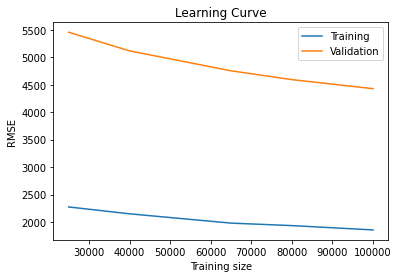

In [480]:
plt.plot(train_sizes, abs(train_scores.mean(axis=1)), label = "Training")
plt.plot(train_sizes, abs(validation_scores.mean(axis=1)), label = "Validation")


plt.ylabel('RMSE')
plt.xlabel('Training size')
plt.title('Learning Curve')
plt.legend()
plt.show()